# 🔎 Exploratory Data Analysis

> See [README-file](../README.md) for more information on how to set up the project.

In [1]:
# ##############
# 📚 Imports
# ##############
from os import path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

## {...} Metadata Analysis

The following paragraphs provide insight on the metadata stored in the Excel files associated with the dataset.

In [ ]:
# Load metadata from Excel files
covid_df = pd.read_excel(
    path.join("..", "data", "COVID.metadata.xlsx"), sheet_name="Sheet1"
)
lung_opacity_df = pd.read_excel(
    path.join("..", "data", "Lung_Opacity.metadata.xlsx"), sheet_name="Sheet1"
)
normal_df = pd.read_excel(
    path.join("..", "data", "Normal.metadata.xlsx"), sheet_name="Sheet1"
)
viral_pneumonia_df = pd.read_excel(
    path.join("..", "data", "Viral Pneumonia.metadata.xlsx"),
    sheet_name="Sheet1",
)

print("===\nGeneral metadata analysis:\n")

# Display information about the datasets
print(
    "COVID dataset:\n- entries:"
    f" {covid_df.shape[0]} ({covid_df.isna().sum().sum()} null-values)\n-"
    f" columns: {covid_df.columns.tolist()}\n"
)
print(
    "Lung Opacity dataset:\n- entries:"
    f" {lung_opacity_df.shape[0]} ({lung_opacity_df.isna().sum().sum()} null-values)\n-"
    f" columns: {lung_opacity_df.columns.tolist()}\n"
)
print(
    "Normal dataset:\n- entries:"
    f" {normal_df.shape[0]} ({normal_df.isna().sum().sum()} null-values)\n-"
    f" columns: {normal_df.columns.tolist()}\n"
)
print(
    "Viral Pneumonia dataset:\n- entries:"
    f" {viral_pneumonia_df.shape[0]} ({viral_pneumonia_df.isna().sum().sum()} null-values)\n-"
    f" columns: {viral_pneumonia_df.columns.tolist()}\n"
)

===
General metadata analysis:

COVID dataset:
- entries: 3616 (0 null-values)
- columns: ['FILE NAME', 'FORMAT', 'SIZE', 'URL']

Lung Opacity dataset:
- entries: 6012 (0 null-values)
- columns: ['FILE NAME', 'FORMAT', 'SIZE', 'URL']

Normal dataset:
- entries: 10192 (0 null-values)
- columns: ['FILE NAME', 'FORMAT', 'SIZE', 'URL']

Viral Pneumonia dataset:
- entries: 1345 (0 null-values)
- columns: ['FILE NAME', 'FORMAT', 'SIZE', 'URL']



In [ ]:
print("===\nImage statistics:\n")

# Image sizes and formats
sizes = pd.concat([
    covid_df["SIZE"],
    lung_opacity_df["SIZE"],
    normal_df["SIZE"],
    viral_pneumonia_df["SIZE"],
]).unique()

# Manually add the size '299*299', since they are missing for the masks.
sizes = np.concatenate([["299*299"], sizes])
sizes = np.unique(sizes)
print(f"- unique sizes: {sizes}")

formats = pd.concat([
    covid_df["FORMAT"],
    lung_opacity_df["FORMAT"],
    normal_df["FORMAT"],
    viral_pneumonia_df["FORMAT"],
]).unique()
print(f"- unique formats: {formats}")

sources = pd.concat([
    covid_df["URL"],
    lung_opacity_df["URL"],
    normal_df["URL"],
    viral_pneumonia_df["URL"],
]).unique()
print(f"- unique sources: {sources}")

===
Image statistics:

- unique sizes: ['256*256' '299*299']
- unique formats: ['PNG']
- unique sources: ['https://sirm.org/category/senza-categoria/covid-19/'
 'https://github.com/ml-workgroup/covid-19-image-repository/tree/master/png'
 'https://eurorad.org' 'https://github.com/armiro/COVID-CXNet'
 'https://github.com/ieee8023/covid-chestxray-dataset'
 'https://bimcv.cipf.es/bimcv-projects/bimcv-covid19/#1590858128006-9e640421-6711'
 'https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data'
 'https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia']


## Image & Mask

Using LIME explanations ([https://github.com/marcotcr/lime](https://github.com/marcotcr/lime)), we found that the model heavily relies on areas external to the abdominal (or even pneumonal regions) for its predictions. The image below illustrates greenish or reddish areas that support the model's decision-making process in a positive or negative way:

![](./static_files/model_explainability-lime.jpg)

As these areas should not have influence on the model decision-making process, it made sense to exclude the irrelevant regions. Therefore, masks are applied to the input images, removing the unwanted parts. With this, it is expected that the model will focus more on the relevant areas and potentially improve its performance.


===
Image & Mask example:

- image size: (299, 299)
- image format: uint8
- image mode: 2
- mask size: (256, 256)
- mask format: uint8
- mask mode: 2
- masked image size: (299, 299)
- masked image format: uint8
- masked image mode: 2


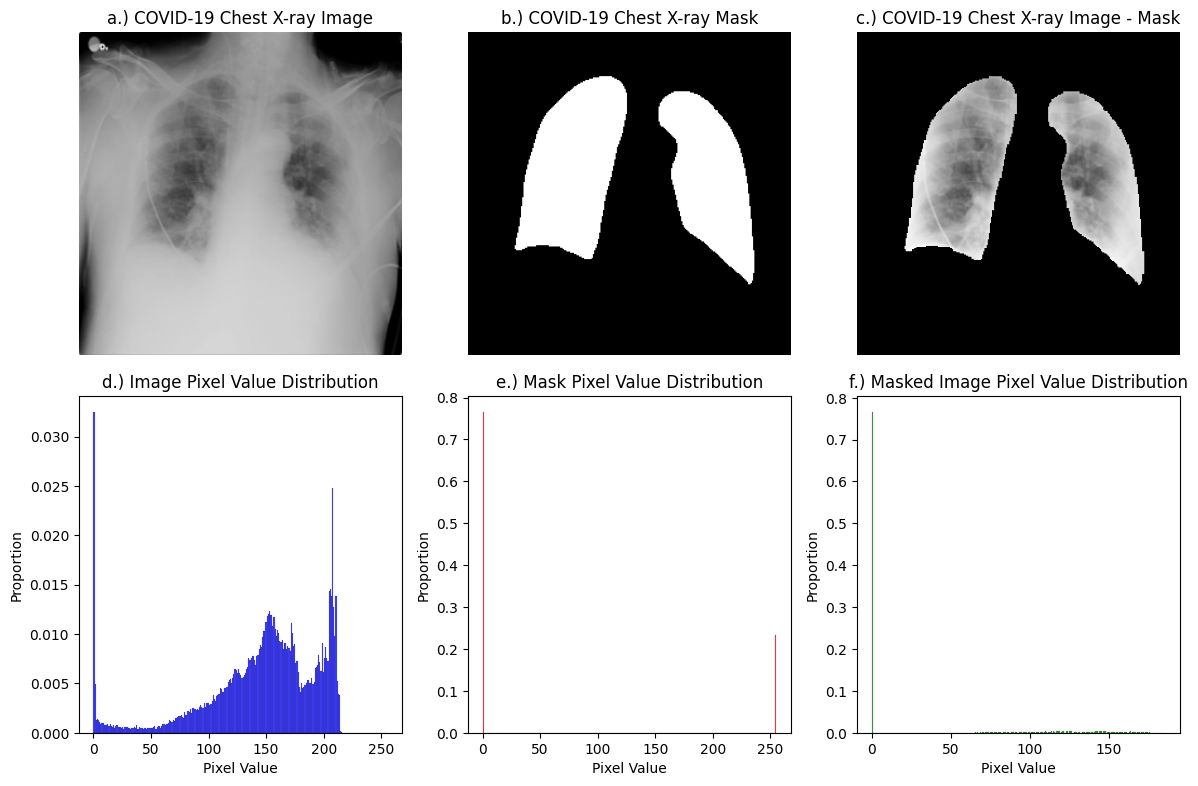

In [ ]:
img = cv2.imread(
    path.join("..", "data", "COVID/images/COVID-1.png"), cv2.IMREAD_GRAYSCALE
)
mask = cv2.imread(
    path.join("..", "data", "COVID/masks/COVID-1.png"), cv2.IMREAD_GRAYSCALE
)
resized_mask = cv2.resize(
    mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST
)
masked_img = img.copy()
masked_img[resized_mask == 0] = 0

# Display the image and mask information
print(f"- image size: {img.shape}")
print(f"- image format: {img.dtype}")
print(f"- image mode: {img.ndim}")
print(f"- mask size: {mask.shape}")
print(f"- mask format: {mask.dtype}")
print(f"- mask mode: {mask.ndim}")
print(f"- masked image size: {masked_img.shape}")
print(f"- masked image format: {masked_img.dtype}")
print(f"- masked image mode: {masked_img.ndim}")

# Display image, mask and histograms of pixel values
fig = plt.figure(figsize=(12, 8))

# Display the image
ax0 = fig.add_subplot(2, 3, 1)
ax0.imshow(img, cmap="gray")
ax0.set_title("a.) COVID-19 Chest X-ray Image")
ax0.axis("off")

# Display the mask
ax1 = fig.add_subplot(2, 3, 2)
ax1.imshow(mask, cmap="gray")
ax1.set_title("b.) COVID-19 Chest X-ray Mask")
ax1.axis("off")

# Apply the segmentation mask to the original image
ax2 = fig.add_subplot(2, 3, 3)
ax2.imshow(masked_img, cmap="gray")
ax2.set_title("c.) COVID-19 Chest X-ray Image - Mask")
ax2.axis("off")

# Display histogram of image
ax3 = fig.add_subplot(2, 3, 4)
sns.histplot(img.ravel(), bins=256, color="blue", ax=ax3, stat="proportion")
ax3.set_title("d.) Image Pixel Value Distribution")
ax3.set_xlabel("Pixel Value")
ax3.set_ylabel("Proportion")

# Display histogram of mask
ax4 = fig.add_subplot(2, 3, 5)
sns.histplot(mask.ravel(), bins=256, color="red", ax=ax4, stat="proportion")
ax4.set_title("e.) Mask Pixel Value Distribution")
ax4.set_xlabel("Pixel Value")
ax4.set_ylabel("Proportion")

ax5 = fig.add_subplot(2, 3, 6)
sns.histplot(
    masked_img.ravel(), bins=256, color="green", ax=ax5, stat="proportion"
)
ax5.set_title("f.) Masked Image Pixel Value Distribution")
ax5.set_xlabel("Pixel Value")
ax5.set_ylabel("Proportion")

fig.tight_layout()
plt.show()

As can be seen in the histogram of image f.), the distribution of pixel values is heavily skewed towards the lower end, indicating most of the image information being cut off by the mask. 